In [25]:
import pandas as pd
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
import seaborn

## Compare similarity of ligand set to DrugBank dataset

In [3]:
# upload the vasopressin dataset
data = pd.read_csv("data/chembl_Vasopressin_V1a_receptor_KI.csv", delimiter = ";")

smiles = data["Smiles"]
smiles.fillna("", inplace = True)
molecules = [Chem.MolFromSmiles(smile) for smile in smiles]
data["molecule"] = molecules

In [4]:
# add MACCS keys to the dataframe
data["MACCSkey"] = data["molecule"].apply(MACCSkeys.GenMACCSKeys)
# add Morgan fingerprints to the dataframe
data["morgan_fingerprint"] = data["molecule"].apply(Chem.GetMorganFingerprintAsBitVect, args = (2, ), nBits = 1024)

In [5]:
# upload the drugbank dataset
drugbank = [m for m in Chem.SDMolSupplier("../data/drugbank.sdf") if m]

RDKit ERROR: [12:50:00] Explicit valence for atom # 7 N, 4, is greater than permitted
[12:50:00] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [12:50:00] ERROR: Could not sanitize molecule ending on line 20009
[12:50:00] ERROR: Could not sanitize molecule ending on line 20009
RDKit ERROR: [12:50:00] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted
[12:50:00] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted
[12:50:01] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10

RDKit ERROR: [12:50:01] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [12:50:01] ERROR: Could not sanitize molecule ending on line 250947
[12:50:01] ERROR: Could not sanitize molecule ending on line 250947
RDKit ERROR: [12:50:01] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [12:50:01] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: 

[12:50:01] ERROR: Could not sanitize molecule ending on line 398455
RDKit ERROR: [12:50:01] ERROR: Explicit valence for atom # 56 O, 3, is greater than permitted
RDKit ERROR: [12:50:01] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 18
RDKit ERROR: 
RDKit ERROR: [12:50:01] ERROR: Could not sanitize molecule ending on line 407765
[12:50:01] ERROR: Explicit valence for atom # 56 O, 3, is greater than permitted
[12:50:01] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 18

[12:50:01] ERROR: Could not sanitize molecule ending on line 407765
RDKit ERROR: [12:50:01] ERROR: Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 18
RDKit ERROR: 
RDKit ERROR: [12:50:01] Explicit valence for atom # 46 Mg, 4, is greater than permitted
RDKit ERROR: [12:50:01] ERROR: Could not sanitize molecule ending on line 417941
[12:50:01] ERROR: Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 18

[12:50:01] Explicit valence for atom # 46 Mg, 4, is greater than permitted
RDKit ERROR: [12:50:01] ERROR: Exp

RDKit ERROR: [12:50:02] Can't kekulize mol.  Unkekulized atoms: 2 3 17 19 20
RDKit ERROR: 
RDKit ERROR: [12:50:02] ERROR: Could not sanitize molecule ending on line 557517
[12:50:02] ERROR: Explicit valence for atom # 6 B, 4, is greater than permitted
[12:50:02] Can't kekulize mol.  Unkekulized atoms: 2 3 17 19 20

RDKit ERROR: [12:50:02] ERROR: Can't kekulize mol.  Unkekulized atoms: 2 3 17 19 20
RDKit ERROR: 
RDKit ERROR: [12:50:02] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [12:50:02] ERROR: Could not sanitize molecule ending on line 561344
RDKit ERROR: [12:50:02] ERROR: Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 8 9 10
[12:50:02] ERROR: Could not sanitize molecule ending on line 557517
[12:50:02] ERROR: Can't kekulize mol.  Unkekulized atoms: 2 3 17 19 20

[12:50:02] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 8 9 10

[12:50:02] ERROR: Could not sanitize molecule ending on line 561344
[12:50:02] ERROR: Can't kekulize

RDKit ERROR: [12:50:02] ERROR: Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 8 9 10
[12:50:02] ERROR: Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 8 9 10

[12:50:03] Explicit valence for atom # 0 Be, 3, is greater than permitted
RDKit ERROR: 
RDKit ERROR: [12:50:03] Explicit valence for atom # 0 Be, 3, is greater than permitted
RDKit ERROR: [12:50:03] ERROR: Could not sanitize molecule ending on line 995692
[12:50:03] ERROR: Could not sanitize molecule ending on line 995692
RDKit ERROR: [12:50:03] ERROR: Explicit valence for atom # 0 Be, 3, is greater than permitted
[12:50:03] ERROR: Explicit valence for atom # 0 Be, 3, is greater than permitted
[12:50:03] Explicit valence for atom # 0 C greater than permitted
RDKit ERROR: [12:50:03] Explicit valence for atom # 0 C greater than permitted
RDKit ERROR: [12:50:03] ERROR: Could not sanitize molecule ending on line 1151592
[12:50:03] ERROR: Could not sanitize molecule ending on line 1151592


In [6]:
# function to return the silimarity index of two bit vectors
def tanimoto_index(bit_vector1, bit_vector2):
    intersect = [bit1 and bit2 for bit1, bit2 in zip(bit_vector1, bit_vector2)]
    union = [bit1 or bit2 for bit1, bit2 in zip(bit_vector1, bit_vector2)]
    index = sum(intersect) / sum(union)
    # index = round(index, 2)
    return index

In [7]:
drugbank_morgan_fingerprint = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits = 1024) for m in drugbank]

In [8]:
drugbank_formulas = [m.GetProp("FORMULA") for m in drugbank]

In [9]:
drugbank_df = pd.DataFrame([drugbank_formulas, drugbank, drugbank_morgan_fingerprint]).transpose()

In [10]:
drugbank_df.columns = ["formula", "molecule", "morgan_fingerprint"]

In [11]:
drugbank_df.loc[:5, ]

,formula,molecule,morgan_fingerprint
0,C98H138N24O33,<rdkit.Chem.rdchem.Mol object at 0x7f975bb45a30>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,C59H84N18O14,<rdkit.Chem.rdchem.Mol object at 0x7f975bb45a80>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,C46H64N14O12S2,<rdkit.Chem.rdchem.Mol object at 0x7f975bb45ad0>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
3,C70H92ClN17O14,<rdkit.Chem.rdchem.Mol object at 0x7f975bb45b20>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,C62H111N11O12,<rdkit.Chem.rdchem.Mol object at 0x7f975bb45c10>,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
5,C46H65N13O11S2,<rdkit.Chem.rdchem.Mol object at 0x7f975bb45c60>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."


In [ ]:
data_subset = data.loc[:50, ]
similarity_matrix = pd.DataFrame(index = drugbank_df.loc[:50, "formula"], columns = data_subset.loc[:50, "Molecule ChEMBL ID"])

for row1 in drugbank_df.index:
    for row2 in data_subset.index:
        name1, fingerprint1 = drugbank_df.loc[row1, ["formula", "morgan_fingerprint"]]
        name2, fingerprint2 = data_subset.loc[row2, ["Molecule ChEMBL ID", "morgan_fingerprint"]]
        
        if tanimoto_index(fingerprint1, fingerprint2) > 0.7:
            similarity_matrix.loc[name1, name2] = tanimoto_index(fingerprint1, fingerprint2)

similarity_matrix = similarity_matrix.add(similarity_matrix.T, fill_value = 0)  # res is upper triangular

In [ ]:
# seradit podle podobnosti, vykreslit matici struktur s legendou drugbank jmeno

## Create a scatter plot of logP and TPSA descriptors for the ligand set and the DrugBank dataset

In [28]:
# calculate the descriptors for the ligand set
data["logP"] = data["molecule"].apply(Descriptors.MolLogP)
data["TPSA"] = data["molecule"].apply(Descriptors.TPSA)

# calculate the descriptors for the drugbank dataset
drugbank_df["logP"] = drugbank_df["molecule"].apply(Descriptors.MolLogP)
drugbank_df["TPSA"] = drugbank_df["molecule"].apply(Descriptors.TPSA)

In [29]:
# combine the dataframes
data["source"] = "vasopressin"
drugbank_df["source"] = "drugbank"

combined_df = data.append(drugbank_df, ignore_index = True)

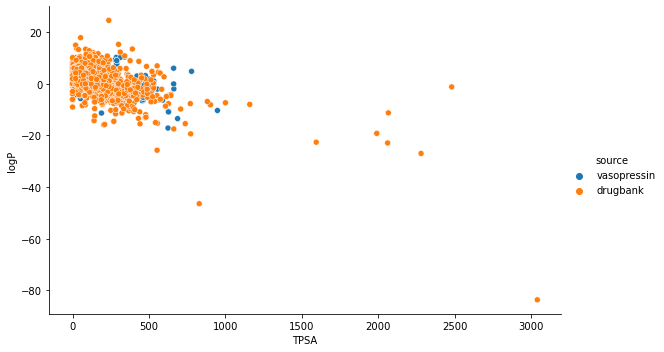

In [32]:
seaborn.relplot(data = combined_df, x = "TPSA", y = "logP", hue = "source", aspect = 1.61)
plt.show()